# 1. 데이터 불러오기

In [24]:
# !pip3 install lightfm
import pandas as pd
import numpy as np
from lightfm.data import Dataset
from scipy.io import mmwrite

# Data Load
ratings = pd.read_csv('/Users/nhn/Desktop/1_dev/0_aiengine/4_data/ml-1m/ratings.dat',sep="::",
                      names=['UserID','MovieID','Rating','Timestamp'], header=None
)

movies = pd.read_csv('/Users/nhn/Desktop/1_dev/0_aiengine/4_data/ml-1m/movies.dat',sep="::",
                      names=['MovieID','Title','Genres'], header=None, encoding='unicode_escape'
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


RATINGS FILE DESCRIPTION
================================================================================

All ratings are contained in the file "ratings.dat" and are in the
following format:

UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

In [25]:
print(ratings.count()[0])
ratings.head()

1000209


,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


MOVIES FILE DESCRIPTION
================================================================================

Movie information is in the file "movies.dat" and is in the following
format:

MovieID::Title::Genres

- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western

- Some MovieIDs do not correspond to a movie due to accidental duplicate
entries and/or test entries
- Movies are mostly entered by hand, so errors and inconsistencies may exist

In [26]:
print(movies.count()[0])
movies.head()

3883


,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


# 2. 전처리

ratings_souce와 item_features_source라는 iterable 객체가 필요하다. 
먼저 전자는 LightFM Dataset class의 build_interactions 메서드의 재료로 활용되며, 
후자의 경우 build_item_features의 재료가 된다. 

In [27]:
import pandas as pd
from lightfm.data import Dataset
from scipy.io import mmwrite

ratings_source = [(ratings['UserID'][i], ratings['MovieID'][i]) for i in range(ratings.shape[0])]

item_meta = pd.merge(movies, 
                     ratings.groupby('MovieID').mean().reset_index()[['MovieID','Rating']], 
                     on='MovieID', how='left')
item_meta = item_meta.reset_index()

item_meta.Rating = item_meta.Rating.fillna(0)
item_features_source = [(item_meta['MovieID'][i],
                        [item_meta['Title'][i],
                         item_meta['Rating'][i]]) for i in range(item_meta.shape[0])]

items 와 features를 매핑 (argument로 들어가는 객체에 결측값은 없어야 합니다.)

In [28]:
item_meta[item_meta.Rating.isna()]

,index,MovieID,Title,Genres,Rating


In [29]:
item_meta[item_meta.Rating == 0]

,index,MovieID,Title,Genres,Rating
50,50,51,Guardian Angel (1994),Action|Drama|Thriller,0.0
107,107,109,Headless Body in Topless Bar (1995),Comedy,0.0
113,113,115,Happiness Is in the Field (1995),Comedy,0.0
141,141,143,Gospa (1995),Drama,0.0
281,281,284,New York Cop (1996),Action|Crime,0.0
...,...,...,...,...,...
3581,3581,3650,Anguish (Angustia) (1986),Horror,0.0
3681,3681,3750,Boricua's Bond (2000),Drama,0.0
3759,3759,3829,Mad About Mambo (2000),Comedy|Romance,0.0
3786,3786,3856,Autumn Heart (1999),Drama,0.0


In [30]:
item_meta

,index,MovieID,Title,Genres,Rating
0,0,1,Toy Story (1995),Animation|Children's|Comedy,4.146846
1,1,2,Jumanji (1995),Adventure|Children's|Fantasy,3.201141
2,2,3,Grumpier Old Men (1995),Comedy|Romance,3.016736
3,3,4,Waiting to Exhale (1995),Comedy|Drama,2.729412
4,4,5,Father of the Bride Part II (1995),Comedy,3.006757
...,...,...,...,...,...
3878,3878,3948,Meet the Parents (2000),Comedy,3.635731
3879,3879,3949,Requiem for a Dream (2000),Drama,4.115132
3880,3880,3950,Tigerland (2000),Drama,3.666667
3881,3881,3951,Two Family House (2000),Drama,3.900000


In [31]:
dataset = Dataset()
dataset.fit(users=ratings['UserID'].unique(),
            items=item_meta['MovieID'].unique(),
            item_features=item_meta[item_meta.columns[1:]].values.flatten()
            )

In [32]:
item_meta

,index,MovieID,Title,Genres,Rating
0,0,1,Toy Story (1995),Animation|Children's|Comedy,4.146846
1,1,2,Jumanji (1995),Adventure|Children's|Fantasy,3.201141
2,2,3,Grumpier Old Men (1995),Comedy|Romance,3.016736
3,3,4,Waiting to Exhale (1995),Comedy|Drama,2.729412
4,4,5,Father of the Bride Part II (1995),Comedy,3.006757
...,...,...,...,...,...
3878,3878,3948,Meet the Parents (2000),Comedy,3.635731
3879,3879,3949,Requiem for a Dream (2000),Drama,4.115132
3880,3880,3950,Tigerland (2000),Drama,3.666667
3881,3881,3951,Two Family House (2000),Drama,3.900000


build를 실행 하여 데이터셋 완성/저장 (희소행렬)

In [33]:
interactions, weights = dataset.build_interactions(ratings_source)
item_features = dataset.build_item_features(item_features_source)

# Save
mmwrite('/Users/nhn/Desktop/1_dev/0_aiengine/3_jupyter/lightFM/interactions.mtx', interactions)
mmwrite('/Users/nhn/Desktop/1_dev/0_aiengine/3_jupyter/lightFM/item_features.mtx', item_features)
mmwrite('/Users/nhn/Desktop/1_dev/0_aiengine/3_jupyter/lightFM/weights.mtx', weights)

# 3. Hyper Parameter 최적화

- no_components, learning_rate 대상 진행
- precision 기준 가장 높은 갚을 선정

In [34]:
from lightfm import cross_validation as CV

# Split Train, Test data
train, test = CV.random_train_test_split(interactions, test_percentage=0.2)
train, test = train.tocsr().tocoo(), test.tocsr().tocoo()
train_weights = train.multiply(weights).tocoo()

In [35]:
# !pip3 install hyperopt
from hyperopt import fmin, hp, tpe, Trials

# Define Search Space
trials = Trials()

epochs_list = range(3, 6)
no_components_list = range(10, 50, 10)
space = [hp.choice('epochs', epochs_list),
         hp.choice('no_components', no_components_list),
         hp.uniform('learning_rate', 0.01, 0.05)]

In [36]:
from lightfm import LightFM
from lightfm import evaluation as EVAL

# Define Objective Function
def objective(params):
    epochs, no_components, learning_rate = params

    model = LightFM(no_components=no_components,
                    learning_schedule='adagrad',
                    loss='warp',
                    learning_rate=learning_rate,
                    random_state=0)

    model.fit(interactions=train,
              item_features=item_features,
              sample_weight=train_weights,
              epochs=epochs,
              verbose=False)
    
    # 모델에 대한 k 메트릭에서 정밀도. 순위가 매겨진 결과 목록의 처음 k 위치에서 알려진 양성 비율입니다. 만점은 1.0입니다.
    test_precision = EVAL.precision_at_k(model, test, k=5, 
                                         item_features=item_features).mean()
    print("no_comp: {}, lrn_rate: {:.5f}, precision: {:.5f}".format(
      no_components, learning_rate, test_precision))
    # test_auc = auc_score(model, test, item_features=item_features).mean()
    output = -test_precision

    if np.abs(output+1) < 0.01 or output < -1.0:
        output = 0.0

    return output

In [37]:
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

no_comp: 10, lrn_rate: 0.03825, precision: 0.12551    
no_comp: 10, lrn_rate: 0.03147, precision: 0.11156                                
no_comp: 40, lrn_rate: 0.03826, precision: 0.12972                                
no_comp: 10, lrn_rate: 0.04756, precision: 0.12382                                
no_comp: 20, lrn_rate: 0.01907, precision: 0.10209                                
no_comp: 40, lrn_rate: 0.02109, precision: 0.12051                                
no_comp: 10, lrn_rate: 0.04381, precision: 0.12694                                
no_comp: 30, lrn_rate: 0.02826, precision: 0.12472                                
no_comp: 40, lrn_rate: 0.02776, precision: 0.12256                                
no_comp: 40, lrn_rate: 0.01799, precision: 0.10696                                
100%|██████████| 10/10 [01:01<00:00,  6.19s/trial, best loss: -0.12972167134284973]


In [38]:
best_params

{'epochs': 0, 'learning_rate': 0.0382627124031652, 'no_components': 3}

# 4. 결과 확인

- 코사인 유사도를 활용 동일 백터에 있는 상위 상품 추천
두 벡터가 가리키는 방향이 얼마나 유사한가
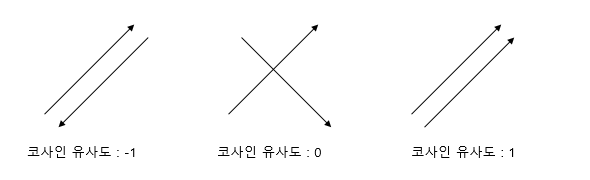

In [39]:
model = LightFM(no_components=no_components_list[best_params['no_components']],
                learning_schedule='adagrad',
                loss='warp',
                learning_rate=best_params['learning_rate'],
                random_state=0)

model.fit(interactions=train,
          item_features=item_features,
          sample_weight=train_weights,
          epochs=epochs_list[1],
          verbose=False)

EVAL.auc_score(model, test, item_features=item_features).mean()

0.90324473

In [40]:
# Find Similar Items
item_biases, item_embeddings = model.get_item_representations(features=item_features)

def make_best_items_report(item_embeddings, MovieID, num_search_items=10):
    item_id = item_meta[item_meta['MovieID'] == MovieID].index[0]

    # Cosine similarity
    scores = item_embeddings.dot(item_embeddings[item_id])  # (10000, )
    item_norms = np.linalg.norm(item_embeddings, axis=1)    # (10000, )
    item_norms[item_norms == 0] = 1e-10
    scores /= item_norms
    
    # best: score가 제일 높은 item의 id를 num_search_items 개 만큼 가져온다.
    best = np.argpartition(scores, -num_search_items)[-num_search_items:]
    similar_item_id_and_scores = sorted(zip(best, scores[best] / item_norms[item_id]),
                                        key=lambda x: -x[1])

    
    
    # Report를 작성할 pandas dataframe
    best_items = pd.DataFrame(columns=['MovieID', 'Title', 'Genres', 'score'])
    for similar_item_id, score in similar_item_id_and_scores:
        try:
            MovieID = item_meta[item_meta['index'] == similar_item_id].values[0][1]
            Title = item_meta[item_meta['index'] == similar_item_id].values[0][2]
            Genres = item_meta[item_meta['index'] == similar_item_id].values[0][3]

            row = pd.Series([MovieID, Title, Genres, score], index=best_items.columns)
            best_items = best_items.append(row, ignore_index=True)
        except Exception:
            return best_items
    return best_items

report01 = make_best_items_report(item_embeddings, 1253, 10)
report02 = make_best_items_report(item_embeddings, 284, 10)

In [41]:
report01

,MovieID,Title,Genres,score
0,1253,"Day the Earth Stood Still, The (1951)",Drama|Sci-Fi,1.000000
1,2287,Them! (1954),Sci-Fi|Thriller|War,0.957952
2,2664,Invasion of the Body Snatchers (1956),Horror|Sci-Fi,0.953865
3,2009,Soylent Green (1973),Sci-Fi|Thriller,0.940554
4,3927,Fantastic Voyage (1966),Adventure|Sci-Fi,0.933550
5,1301,Forbidden Planet (1956),Sci-Fi,0.932628
6,2662,"War of the Worlds, The (1953)",Action|Sci-Fi|War,0.931902
7,2346,"Stepford Wives, The (1975)",Sci-Fi|Thriller,0.931871
8,674,Barbarella (1968),Adventure|Sci-Fi,0.907925
9,940,"Adventures of Robin Hood, The (1938)",Action|Adventure,0.903280


In [42]:
report02

,MovieID,Title,Genres,score
0,284,New York Cop (1996),Action|Crime,1.000000
1,1065,"Woman in Question, The (1950)",Mystery,0.999553
2,1368,"Forbidden Christ, The (Cristo proibito, Il) (1...",Drama,0.999421
3,873,Shadow of Angels (Schatten der Engel) (1976),Drama,0.999384
4,777,Pharaoh's Army (1995),War,0.999332
5,676,They Bite (1996),Drama,0.999152
6,3561,Stacy's Knights (1982),Drama,0.999148
7,3856,Autumn Heart (1999),Drama,0.999146
8,2910,"Ennui, L' (1998)",Drama|Romance,0.999134
9,1318,Blue Juice (1995),Comedy|Drama,0.999133


In [73]:
item_embeddings

array([[ 0.30679435,  0.3974905 ,  0.34992367, ...,  0.42181915,
        -0.29025304,  0.29561257],
       [ 0.3023495 ,  0.18667029,  0.18188117, ...,  0.3052559 ,
        -0.08100879,  0.12230317],
       [ 0.20119895,  0.04676199,  0.04246473, ...,  0.17345712,
        -0.18789303,  0.26941988],
       ...,
       [-0.05690535, -0.09319206,  0.00140353, ..., -0.09330348,
        -0.00414974,  0.03913517],
       [-0.31496125, -0.2595631 , -0.16325764, ..., -0.20627123,
         0.21298306, -0.199289  ],
       [-0.13955672,  0.01309465,  0.13578786, ..., -0.06218607,
        -0.0743687 ,  0.04601671]], dtype=float32)

In [55]:
np.linalg.norm(item_embeddings, axis=1)

array([2.3675747, 1.8471233, 1.4978939, ..., 0.8112144, 1.5764465,
       1.472321 ], dtype=float32)

In [72]:
a=np.linalg.norm(item_embeddings, axis=1)
a[a == 0] = 1e-10
a

array([2.3675747, 1.8471233, 1.4978939, ..., 0.8112144, 1.5764465,
       1.472321 ], dtype=float32)

In [79]:
item_embeddings.dot(item_embeddings[1])

array([ 3.1511397,  3.4118643,  2.0785081, ..., -0.9398352, -2.1623316,
       -1.1426682], dtype=float32)

In [80]:
item_embeddings.dot(item_embeddings[1])/a

array([ 1.3309568,  1.8471233,  1.3876203, ..., -1.1585534, -1.3716491,
       -0.7760999], dtype=float32)

In [67]:
item_embeddings.dot(1)

array([[ 0.30679435,  0.3974905 ,  0.34992367, ...,  0.42181915,
        -0.29025304,  0.29561257],
       [ 0.30234951,  0.18667029,  0.18188117, ...,  0.30525589,
        -0.08100879,  0.12230317],
       [ 0.20119895,  0.04676199,  0.04246473, ...,  0.17345712,
        -0.18789303,  0.26941988],
       ...,
       [-0.05690535, -0.09319206,  0.00140353, ..., -0.09330348,
        -0.00414974,  0.03913517],
       [-0.31496125, -0.25956309, -0.16325764, ..., -0.20627123,
         0.21298306, -0.19928899],
       [-0.13955672,  0.01309465,  0.13578786, ..., -0.06218607,
        -0.0743687 ,  0.04601671]])

# 1. 데이터 불러오기
- user_features 반영 predic 활용 예시

In [14]:
# Data Load
users = pd.read_csv('/Users/nhn/Desktop/1_dev/0_aiengine/4_data/ml-1m/users.dat',sep="::",
                      names=['UserID','Gender','Age','Occupation','Zip-code'], header=None
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [15]:
print(users.count()[0])
users.head()

6040


,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


# 2. 전처리
- user_features_source iterable 객체의 경우 build_user_features의 재료가 된다.

In [16]:
user_features_source = [(users['UserID'][i],
             [users['Gender'][i],
              users['Age'][i],
              users['Occupation'][i],
              users['Zip-code'][i]]
             ) for i in range(users.shape[0])]

users/items 와 features를 매핑 (argument로 들어가는 객체에 결측값은 없어야 합니다.)

In [17]:
dataset = Dataset()
dataset.fit(users=ratings['UserID'].unique(),
            items=item_meta['MovieID'].unique(),
            item_features=item_meta[item_meta.columns[1:]].values.flatten(),
            user_features=users[users.columns[1:]].values.flatten()
            )

build를 실행 하여 데이터셋 완성/저장

In [18]:
interactions, weights = dataset.build_interactions(ratings_source)
user_features = dataset.build_user_features(user_features_source)
item_features = dataset.build_item_features(item_features_source)


# Save
mmwrite('/Users/nhn/Desktop/1_dev/0_aiengine/3_jupyter/lightFM/interactions.mtx', interactions)
mmwrite('/Users/nhn/Desktop/1_dev/0_aiengine/3_jupyter/lightFM/item_features.mtx', item_features)
mmwrite('/Users/nhn/Desktop/1_dev/0_aiengine/3_jupyter/lightFM/user_features.mtx', user_features)
mmwrite('/Users/nhn/Desktop/1_dev/0_aiengine/3_jupyter/lightFM/weights.mtx', weights)

# 3. Hyper Parameter 최적화

In [19]:
from lightfm import cross_validation as CV

# Split Train, Test data
train, test = CV.random_train_test_split(interactions, test_percentage=0.2)
train, test = train.tocsr().tocoo(), test.tocsr().tocoo()
train_weights = train.multiply(weights).tocoo()

In [20]:
# !pip3 install hyperopt
from hyperopt import fmin, hp, tpe, Trials

# Define Search Space
trials = Trials()

epochs_list = range(3, 6)
no_components_list = range(10, 50, 10)
space = [hp.choice('epochs', epochs_list),
         hp.choice('no_components', range(10, 50, 10)),
         hp.uniform('learning_rate', 0.01, 0.05)]

In [21]:
from lightfm import LightFM
from lightfm import evaluation as EVAL

# Define Objective Function
def objective(params):
    epochs, no_components, learning_rate = params
    
    model = LightFM(no_components=no_components,
                    learning_schedule='adagrad',
                    loss='warp',
                    learning_rate=learning_rate,
                    random_state=0)

    model.fit(interactions=train,
              item_features=item_features,
              user_features=user_features,
              sample_weight=train_weights,
              epochs=epochs,
              verbose=False)

    test_precision = EVAL.precision_at_k(model, test, k=5, 
                                         item_features=item_features, 
                                         user_features=user_features).mean()
    print("epochs {}, no_comp: {}, lrn_rate: {:.5f}, precision: {:.5f}".format(
        epochs, no_components, learning_rate, test_precision))
    # test_auc = auc_score(model, test, item_features=item_features).mean()
    output = -test_precision

    if np.abs(output+1) < 0.01 or output < -1.0:
        output = 0.0

    return output

In [22]:
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

epochs 3, no_comp: 30, lrn_rate: 0.03110, precision: 0.10305
epochs 5, no_comp: 40, lrn_rate: 0.02322, precision: 0.10093                      
epochs 3, no_comp: 20, lrn_rate: 0.04884, precision: 0.10494                      
epochs 5, no_comp: 30, lrn_rate: 0.01913, precision: 0.09844                      
epochs 5, no_comp: 30, lrn_rate: 0.02251, precision: 0.10119                      
 50%|█████     | 5/10 [00:49<00:49,  9.96s/trial, best loss: -0.10494031757116318]


KeyboardInterrupt: 

In [ ]:
model = LightFM(no_components=no_components_list[best_params['no_components']],
                learning_schedule='adagrad',
                loss='warp',
                learning_rate=best_params['learning_rate'],
                random_state=0)

model.fit(interactions=train,
          item_features=item_features,
          user_features=user_features,
          sample_weight=train_weights,
          epochs=epochs_list[best_params['epochs']],
          verbose=False)

EVAL.auc_score(model, test, item_features=item_features, user_features=user_features).mean()

In [ ]:
# user id 3에 영화를 추천할 경우 예측점수
model.predict(3, item_meta['index'].unique(),
          item_features=item_features,
          user_features=user_features)

In [270]:
# 복수 사용자에게 영화 추천 예측점수
# predict 사용 시 user와 item의 배열 크기는 동일해야 함.
# user[1,2,3] , item[a,b,c] -> prdict[1-a, 2-b, 3-c]
model.predict(ratings['UserID'].unique()[:3700], item_meta['index'].unique()[0:3700],item_features=item_features,
          user_features=user_features)

array([-35.70082 , -45.17685 , -45.906155, ..., -23.621445, -44.799156,
       -42.778   ], dtype=float32)

In [271]:
# movie id 3468 을 복수 사용자에게 추천할 경우 예측점수
model.predict(ratings['UserID'].unique()[:3700], 
              [item_meta[item_meta['MovieID'] == 3468].index[0]] * 3700,
              item_features=item_features,
              user_features=user_features)

array([-36.363426, -45.987415, -45.119217, ..., -20.897898, -43.47826 ,
       -40.595844], dtype=float32)

In [228]:
len(ratings['UserID'].unique())

6040

In [229]:
len(item_meta['MovieID'].unique())

3706